Configuración e Importaciones

In [1]:
# Celda 1: Importaciones
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import os
import joblib
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

# Celda 2: Carga del modelo de spacy y semilla
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
seed = 42

Carga y Preprocesamiento de Datos

In [ ]:


# --- MÉTODO RECOMENDADO PARA MUESTREO EXACTO ---

try:
    # 1. Definir los parámetros
    ruta_archivo = 'data/training.1600000.processed.noemoticon.csv'
    total_filas = 1600000
    filas_a_leer = 1600 # El número exacto que quieres
    
    # 2. Calcular cuántas filas necesitamos omitir
    filas_a_omitir = total_filas - filas_a_leer

    # 3. Generar una lista aleatoria de índices de fila para omitir
    # Creamos una lista de todos los posibles índices (del 0 al 1,599,999)
    # y elegimos al azar los que vamos a saltar.
    indices_a_omitir = random.sample(range(total_filas), k=filas_a_omitir)

    # 4. Cargar el CSV omitiendo los índices que calculamos
    # Como no hay encabezado (header=None), los índices de las filas empiezan en 0.
    df = pd.read_csv(
        ruta_archivo,
        encoding='latin-1',
        header=None,
        skiprows=indices_a_omitir
    )
    
    print(f"✅ DataFrame cargado con exactamente {len(df)} filas.")
    
    # --- Tu código de procesamiento continúa igual ---
    
    # Asignar nombres a las columnas
    df.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Eliminar columnas innecesarias
    cols_to_drop = ['id', 'date', 'query']
    df = df.drop(columns=cols_to_drop)
    
    print("\nProcesamiento inicial completado.")
    print(df.sample(10))
    
except FileNotFoundError:
    print(f"Error: El archivo no fue encontrado en la ruta: {ruta_archivo}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

if 'df' in locals():
    # El valor 0 es Negativo y 4 es Positivo.
    df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 4: 'Positive', 2: 'Neutro??'})
    
    # Creamos la copia después del mapeo
    df_copy = df.copy()

    print('Distribución de sentimientos tras el mapeo:')
    print(df['Sentiment'].value_counts())

✅ DataFrame cargado con exactamente 1600 filas.

Procesamiento inicial completado.
   Sentiment          user                                               Text
0          0    Jenoah1908  my poor little girl has a baaaad rash on her b...
1          0      djodcouk  @helenthornber I dunno but I used to get fruit...
2          0  MistyMoopies  @NathanaelB awww no fair! i is a big girl but ...
3          0  amymuirphoto  is photographing This Is Hell tonight!!! Damn,...
4          0      mscheeve  i am trying to navigate around modern techonol...
5          0  mrsnickhodge                 Arrrggh, #failwhale strikes again 
6          0   semipenguin                     Coffee &amp; cigarettes. Blah 
7          0    flipflip81  @nick_carter http://twitpic.com/3i25t - mmmm G...
8          0   omgcupcakez  i feel ridiculous. and i'm blaming you.  WHY H...
9          0   yrujealous1                            getting ready for work 
Distribución de sentimientos tras el mapeo:
Sentiment
Posit

Análisis Exploratorio de Datos (EDA)

Generando nubes de palabras...


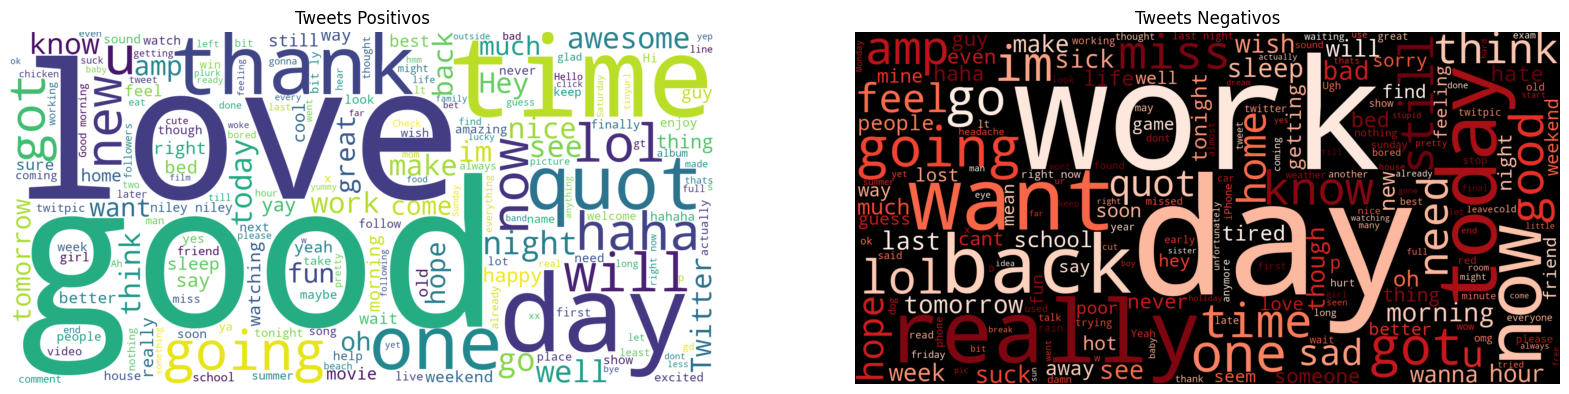

In [4]:
# Celda 5: Nube de Palabras
if 'df_copy' in locals():
    print("Generando nubes de palabras...")
    positive_tweets = df_copy[df_copy['Sentiment'] == 'Positive']['Text'].str.cat(sep=' ')
    negative_tweets = df_copy[df_copy['Sentiment'] == 'Negative']['Text'].str.cat(sep=' ')

    wordcloud_pos = WordCloud(width=1600, height=800, background_color='white').generate(positive_tweets)
    wordcloud_neg = WordCloud(width=1600, height=800, background_color='black', colormap='Reds').generate(negative_tweets)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Tweets Positivos')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Tweets Negativos')
    plt.axis('off')
    plt.show()

Preparación para el Modelo | Se intenta cargar el split_data.joblib, si no lo logra se ejecuta la limpieza y se guarda.

In [5]:

# --- Intenta cargar los datos preprocesados ---
try:
    ruta_archivo_joblib = 'data_processed/split_data_prueba.joblib'
    datos_cargados = joblib.load(ruta_archivo_joblib)
    X_train = datos_cargados['X_train']
    X_test = datos_cargados['X_test']
    y_train = datos_cargados['y_train']
    y_test = datos_cargados['y_test']
    print("✅ Datos preprocesados cargados exitosamente desde el archivo.")

# --- Si no los encuentra, ejecuta la limpieza y el guardado ---
except FileNotFoundError:
    print("⚠️ Archivo 'split_data.joblib' no encontrado. Ejecutando el preprocesamiento...")
    if 'df' in locals():
        # Función de limpieza (asegúrate de que esté definida previamente)
        def limpieza(texto):
            if not isinstance(texto, str):
                return ""
            texto = texto.lower()
            texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
            texto = re.sub(r'\s+', ' ', texto).strip()
            if not texto:
                return ""
            doc = nlp(texto)
            return ' '.join([token.lemma_ for token in doc if not token.is_stop])

        # Preparación y división de los datos
        X = df['Text'].apply(limpieza)
        y = df['Sentiment'].map({'Negative': -1, 'Positive': 1})

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

        # Guardado de los datos procesados
        output_dir = 'data_processed'
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'split_data_prueba.joblib')
        joblib.dump({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}, output_path)
        print(f"💾 Datos procesados y guardados en: '{output_path}'")
    else:
        print("❌ Error: El DataFrame 'df' no está definido. Asegúrate de cargarlo primero.")

⚠️ Archivo 'split_data.joblib' no encontrado. Ejecutando el preprocesamiento...
💾 Datos procesados y guardados en: 'data_processed\split_data_prueba.joblib'


Entrenamiento y Evaluación del Modelo

Paso 1: Realizando vectorización TF-IDF optimizada...
Vectorización completada.

Paso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...
Mejores parámetros encontrados: {'C': 1}

Paso 3: Evaluando el mejor modelo encontrado...

--- Reporte de Clasificación (Train) ---
              precision    recall  f1-score   support

          -1       0.77      0.73      0.75       540
           1       0.76      0.80      0.78       580

    accuracy                           0.77      1120
   macro avg       0.77      0.77      0.77      1120
weighted avg       0.77      0.77      0.77      1120


--- Reporte de Clasificación (Test) ---
              precision    recall  f1-score   support

          -1       0.65      0.64      0.64       232
           1       0.67      0.68      0.67       248

    accuracy                           0.66       480
   macro avg       0.66      0.66      0.66       480
weighted avg       0.66      0.66      0.66       480



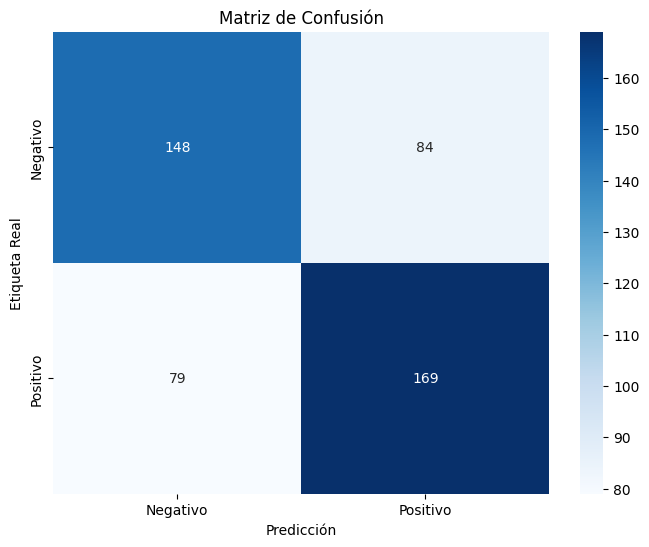


✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta 'model_pruebas'.


In [6]:
# Celda 8: Vectorización y Optimización del Modelo
print("Paso 1: Realizando vectorización TF-IDF optimizada...")
vectorizer_tfidf_opt = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, min_df=5, max_df=0.7)
X_train_tfidf_opt = vectorizer_tfidf_opt.fit_transform(X_train)
X_test_tfidf_opt = vectorizer_tfidf_opt.transform(X_test)
print("Vectorización completada.")

print("\nPaso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...")
model_lr = LogisticRegression(random_state=seed, max_iter=1000)
param_grid = {'C': [0.1, 0.5, 1]}
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf_opt, y_train)
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Celda 9: Evaluación del Mejor Modelo
best_model_lr = grid_search.best_estimator_
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)

# --- 3. Evaluando el mejor modelo encontrado ---
print("\nPaso 3: Evaluando el mejor modelo encontrado...")

# 'best_estimator_' es el modelo ya entrenado con el mejor 'C'
best_model_lr = grid_search.best_estimator_

# --- Reporte de Clasificación (Train) ---
print("\n--- Reporte de Clasificación (Train) ---")
y_train_pred = best_model_lr.predict(X_train_tfidf_opt)
print(classification_report(y_train, y_train_pred))

# --- Reporte de Clasificación (Test) ---
print("\n--- Reporte de Clasificación (Test) ---")
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)
print(classification_report(y_test, y_test_pred))

# Celda 10: Matriz de Confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# Celda 11: Guardado del Modelo y Vectorizador Final
output_dir = 'model_pruebas'
os.makedirs(output_dir, exist_ok=True)
joblib.dump(vectorizer_tfidf_opt, os.path.join(output_dir, 'schimizzi_vectorizer_prueba.joblib'))
joblib.dump(best_model_lr, os.path.join(output_dir, 'schimizzi_modelo_prueba.joblib'))
print(f"\n✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta '{output_dir}'.")


In [7]:
import pandas as pd
import numpy as np

print("\n--- Opción 2: Top 20 Palabras Más Relevantes (TF-IDF) ---")

# Asegurarnos de que los objetos del modelo optimizado existan
if 'vectorizer_tfidf_opt' in locals() and 'X_train_tfidf_opt' in locals():
    # 1. Obtenemos el puntaje TF-IDF promedio para cada palabra
    # Esto nos da una idea de la importancia general de cada término en el corpus
    avg_tfidf_scores = np.asarray(X_train_tfidf_opt.mean(axis=0)).ravel()
    
    # 2. Creamos un DataFrame con las palabras y sus puntajes promedio
    df_relevancia = pd.DataFrame({
        'palabra': vectorizer_tfidf_opt.get_feature_names_out(),
        'relevancia_tfidf': avg_tfidf_scores
    })
    
    # 3. Ordenamos por relevancia y mostramos las 20 más importantes
    df_relevancia_ordenada = df_relevancia.sort_values(by='relevancia_tfidf', ascending=False)
    
    print(df_relevancia_ordenada.head(20))
else:
    print("⚠️ Error: El 'vectorizer_tfidf_opt' o 'X_train_tfidf_opt' no están definidos.")
    print("Asegúrate de haber ejecutado la celda del modelo optimizado (GridSearchCV).")


--- Opción 2: Top 20 Palabras Más Relevantes (TF-IDF) ---
    palabra  relevancia_tfidf
155     not          0.041521
42      day          0.031265
82     good          0.026781
122    like          0.024126
136    love          0.023857
79       go          0.023552
75      get          0.021774
251    want          0.021731
230    time          0.021588
263    work          0.020986
228   think          0.020258
145    miss          0.018348
130     lol          0.015962
233   today          0.015786
58     feel          0.015222
117    know          0.014611
88     haha          0.014587
226   thank          0.014546
262    wish          0.014378
106    hope          0.013395


In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

print("--- Opción 1: Top 20 Palabras Más Frecuentes ---")

# Asegurarnos de que X_train (el texto limpio) exista
if 'X_train' in locals():
    # 1. Usamos CountVectorizer para contar la frecuencia de cada palabra
    count_vectorizer = CountVectorizer()
    word_counts = count_vectorizer.fit_transform(X_train)
    
    # 2. Sumamos las apariciones de cada palabra en todos los documentos
    total_counts = word_counts.sum(axis=0)
    
    # 3. Creamos un DataFrame para visualizar los resultados
    df_frecuencia = pd.DataFrame({
        'palabra': count_vectorizer.get_feature_names_out(),
        'frecuencia': total_counts.getA1()  # .getA1() convierte la matriz a un array plano
    })
    
    # 4. Ordenamos por frecuencia y mostramos las 20 más comunes
    df_frecuencia_ordenada = df_frecuencia.sort_values(by='frecuencia', ascending=False)
    
    print(df_frecuencia_ordenada.head(30))

else:
    print("⚠️ Error: La variable 'X_train' no está definida. Asegúrate de haber ejecutado la celda de preprocesamiento.")

--- Opción 1: Top 20 Palabras Más Frecuentes ---
       palabra  frecuencia
2075       not         150
708        day          76
1153      good          73
1144        go          70
1707      like          69
1752      love          58
3240      work          57
1123       get          54
2947      time          52
3157      want          50
2921     think          45
998       feel          43
1919      miss          39
1735       lol          37
1629      know          37
2963     today          37
2048     night          36
1215      haha          34
1325      hope          34
2902     thank          31
3218      wish          29
1953   morning          28
2666     sleep          28
2031       new          27
98         amp          26
583       come          26
1312      home          26
1093       fun          25
2977  tomorrow          24
3149      wait          24


Uso del Modelo Guardado para Predicciones

In [ ]:

# --- 1. Cargar el modelo de lenguaje de Spacy ---
# Esto es necesario para que la función 'limpieza' funcione.
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# --- 2. Definir la función de limpieza ---
# Esta debe ser la misma función que usaste para entrenar el modelo.
def limpieza(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    if not texto:
        return ""
    doc = nlp(texto)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

# --- 3. Cargar el modelo y el vectorizador guardados ---
try:
    vectorizer_cargado = joblib.load('model_pruebas/schimizzi_vectorizer_prueba.joblib')
    modelo_cargado = joblib.load('model_pruebas/schimizzi_modelo_prueba.joblib')
    print("Vectorizer y modelo cargados correctamente.\n")

    # --- 4. Preparar y predecir sobre datos nuevos ---
    df_nuevos = pd.read_csv('data/testdata.manual.2009.06.14.csv', header=None, encoding='latin-1')
    df_nuevos.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Aplicar la limpieza a los nuevos datos
    nuevos_datos_limpios = df_nuevos['Text'].apply(limpieza)
    
    # Transformar los datos limpios con el vectorizador cargado
    nuevos_datos_tfidf = vectorizer_cargado.transform(nuevos_datos_limpios)
    
    # Realizar la predicción
    predicciones = modelo_cargado.predict(nuevos_datos_tfidf)
    
    # Mostrar resultados
    mapa_sentimiento = {-1: "Negativo", 1: "Positivo"}
    df_nuevos['Prediccion'] = [mapa_sentimiento[p] for p in predicciones]
    
    print("--- Muestra de Predicciones sobre Datos Nuevos ---")
    print(df_nuevos[['Text', 'Prediccion']].sample(20))

except FileNotFoundError:
    print("\nError: Asegúrate de que los archivos 'schimizzi_vectorizer_final.joblib' y 'schimizzi_modelo_final.joblib' estén en la carpeta 'model_robust'.")

Vectorizer y modelo cargados correctamente.

--- Muestra de Predicciones sobre Datos Nuevos ---
                                                 Text Prediccion
0   @stellargirl I loooooooovvvvvveee my Kindle2. ...   Positivo
1   Reading my kindle2...  Love it... Lee childs i...   Positivo
2   Ok, first assesment of the #kindle2 ...it fuck...   Negativo
3   @kenburbary You'll love your Kindle2. I've had...   Positivo
4   @mikefish  Fair enough. But i have the Kindle2...   Negativo
5   @richardebaker no. it is too big. I'm quite ha...   Positivo
6   Fuck this economy. I hate aig and their non lo...   Negativo
7                       Jquery is my new best friend.   Positivo
8                                       Loves twitter   Positivo
9   how can you not love Obama? he makes jokes abo...   Positivo
10  Check this video out -- President Obama at the...   Positivo
11  @Karoli I firmly believe that Obama/Pelosi hav...   Negativo
12  House Correspondents dinner was last night who...   Pos